In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

In [30]:
def get_image(img):
  transform = transforms.Compose([transforms.ToTensor()])
  transformed_image = transform(img)
  #Create the batch
  img = torch.unsqueeze(transformed_image, dim = 0)
  return img

In [3]:
def plot_images(img, fish_out, hwave_out):
  fish = fish_out[0].numpy()
  hwave = hwave_out[0].numpy()

  fish = np.moveaxis(fish, 0, -1)
  hwave = np.moveaxis(hwave, 0, -1)
  f, ax = plt.subplots(1, 3, figsize = (16,12))
  ax[0].imshow(img)
  ax[1].imshow(fish)
  ax[2].imshow(hwave)

  ax[0].set_title('Input')
  ax[1].set_title('Fisheye Transform')
  ax[2].set_title('Horizontal Wave Transform')

  plt.show()

In [20]:
def fisheye(h, w, center, distortion):
  xx = torch.linspace(-1,1,w)
  yy = torch.linspace(-1,1,h)
  grid_y, grid_x = torch.meshgrid(yy, xx)
  grid = torch.stack([grid_x, grid_y], dim=-1)
  dist = center - grid
  sum_dist = torch.sqrt((dist**2).sum(axis = -1))
  #transform the Original Grid 
  grid = grid + (dist * sum_dist.unsqueeze(-1) * distortion)
  return grid.unsqueeze(0) #4D grid, take [0] when plotting

In [40]:
def HWave(h, w, frequency, amplitude):
  xx = torch.linspace(-1,1,w)
  yy = torch.linspace(-1,1,h)
  grid_y, grid_x = torch.meshgrid(yy, xx)
  grid = torch.stack([grid_x, grid_y], dim=-1)
  term = amplitude * torch.cos(frequency * grid[:,:,0])
  #transform the Original Grid 
  grid[:,:,1] += term
  return grid.unsqueeze(0) #4D grid, take [0] when plotting

In [26]:
!wget -O checker.png https://upload.wikimedia.org/wikipedia/commons/thumb/7/70/Checkerboard_pattern.svg/1200px-Checkerboard_pattern.svg.png

--2021-03-15 08:59:43--  https://upload.wikimedia.org/wikipedia/commons/thumb/7/70/Checkerboard_pattern.svg/1200px-Checkerboard_pattern.svg.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8632 (8.4K) [image/png]
Saving to: ‘checker.png’

checker.png         100%[===================>]   8.43K  --.-KB/s    in 0s      

2021-03-15 08:59:43 (152 MB/s) - ‘checker.png’ saved [8632/8632]



In [32]:
img = Image.open('checker.png')
imgs = get_image(img)
n, c, h, w = imgs.shape

In [41]:
center = torch.tensor([0,0])
fisheye_grid = fisheye(h, w, center, 0.4)
hwave_grid = HWave(h, w, 10, 0.1)

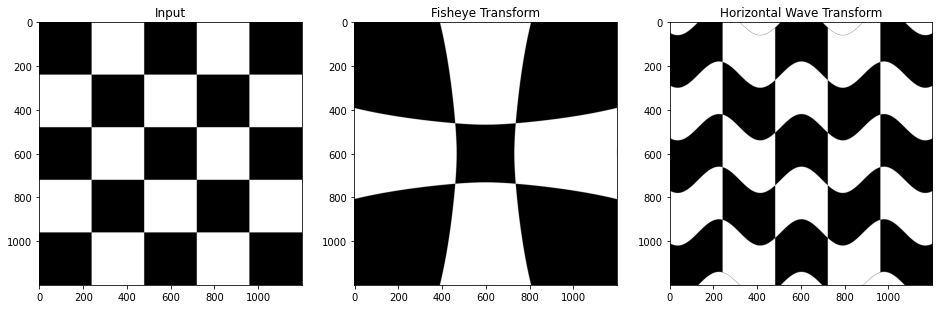

In [42]:
fisheye_output = F.grid_sample(imgs, fisheye_grid, align_corners=True)
hwave_output = F.grid_sample(imgs, hwave_grid, align_corners=True)
plot_images(img, fisheye_output, hwave_output)